In [ ]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('src')

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import PreTrainedTokenizerFast, pipeline
from tqdm.auto import tqdm

from csbm.data import AmazonDataset, YelpDataset, DiscreteGaussianDataset, Prior
from csbm.utils import convert_to_numpy, fig2img, visualize_trajectory_toy
from csbm.models.toy import D3PM

import seaborn as sns
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
tokenizer = PreTrainedTokenizerFast(
    tokenizer_file='checkpoints/tokenizer_amazon.json',
    padding_side='right',
    truncation_side='right',
    bos_token='<s>',
    pad_token='<pad>',
    unk_token='<unk>',
)
dataset = AmazonDataset(
    sentiment='all', 
    data_dir='data', 
    # tokenizer=tokenizer,
    # max_length=45,
    split='all',
)

In [ ]:
from tqdm import tqdm

max_length = 0
pbar = tqdm(dataset, desc=f'max_length: {max_length}') # type: ignore
for text in pbar:
    lenght = len(tokenizer.encode(text))
    if lenght > max_length:
        max_length = lenght
        pbar.set_description(f'max_length: {max_length}')


In [ ]:
trainset = pd.read_json('data/amazon/amazon_small_train.jsonl', lines=True)
testset = pd.read_json('data/amazon/amazon_small_test.jsonl', lines=True)
evalset = pd.read_json('data/amazon/amazon_small_eval.jsonl', lines=True)

In [ ]:
trainset.to_json('data/amazon/amazon_small_train.jsonl', lines=True, orient='records')
testset.to_json('data/amazon/amazon_small_test.jsonl', lines=True, orient='records')
evalset.to_json('data/amazon/amazon_small_eval.jsonl', lines=True, orient='records')

In [ ]:
# allset = pd.concat([trainset, testset, evalset], ignore_index=True)
# allset.to_json('data/yelp/amazon_small_all.jsonl', orient='records', lines=True)
allset = pd.read_json('data/amazon/amazon_small_allset.jsonl', lines=True)

In [ ]:
len(allset)

In [ ]:
!which python

In [ ]:
from csbm.data import AmazonDataset

dataset = AmazonDataset(sentiment='all', data_dir='data/', split='all')
len(dataset)

In [ ]:
device = 'cpu'

In [ ]:
num_categories = 10
num_timesteps = 10

dataset = DiscreteGaussianDataset(5000, dim=2, num_categories=num_categories, train=False)

In [264]:
global_min = 0.0
global_max = 1

cmap = 'inferno'

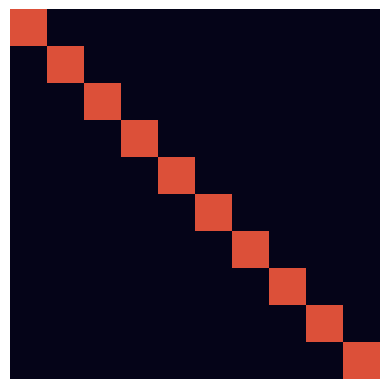

In [278]:
alpha = 0.4

prior = Prior(
    alpha=alpha, 
    num_categories=num_categories, 
    num_timesteps=num_timesteps, 
    num_skip_steps=1, 
    prior_type='uniform',
    eps=1e-20,
).to(device)

plt.figure(frameon=False)
plt.imshow(prior.p_onestep, vmin=global_min, vmax=global_max, cmap=cmap)
plt.axis('off') 
plt.show()


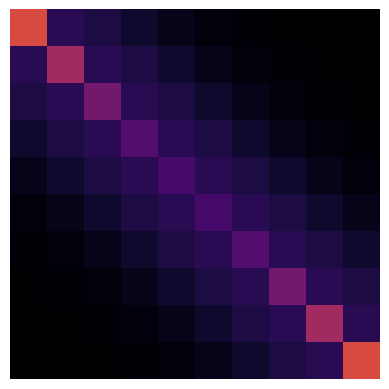

In [274]:
alpha = 0.8

prior = Prior(
    alpha=alpha, 
    num_categories=num_categories, 
    num_timesteps=num_timesteps, 
    num_skip_steps=1, 
    prior_type='gaussian',
    eps=1e-20,
).to(device)

plt.figure(frameon=False)
plt.imshow(prior.p_onestep, vmin=global_min, vmax=global_max, cmap=cmap)
plt.axis('off') 
plt.show()

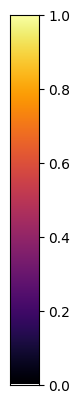

In [267]:
gradient = np.linspace(global_min, global_max, 256)
plt.figure(frameon=False)
plt.imshow(
    gradient[:, None], aspect=0.05, origin='lower', cmap=cmap,
    extent=(0, global_max/len(gradient), 0, global_max)
)
plt.xticks([])
plt.gca().yaxis.tick_right()
plt.show()

In [ ]:
num_trajectories = 1
traj_start = torch.tensor([[20, 4]]).to(device)
traj_end = torch.tensor([[2, 12]]).to(device)

trajectory = [traj_start]
for t in range(num_timesteps):
    t = torch.full((num_trajectories,), t, device=device)
    trajectory.append(prior.sample_bridge(traj_start, traj_end, t))
trajectory.append(traj_end)
trajectory = torch.stack(trajectory)

trajectory = convert_to_numpy(trajectory)
visualize_trajectory_toy(dataset[:5000], trajectory, fb='forward', dpi=100)